**Importing**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("/content/drive/MyDrive/Competitions/KDAG/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Competitions/KDAG/test.csv")

**Adding coeff to train**

In [17]:
train['coeff'] = train['profit']/train['price']

**Dropping useless columns from both**

In [18]:
train = train.drop(['departure city', 'no of items', 'segment', 'delivery type', 'RID', 'delivery date', 'address code', 'placement date'], axis=1)
test = test.drop(['departure city', 'no of items', 'segment', 'delivery type', 'RID', 'delivery date', 'address code', 'placement date'], axis=1)

**Integer Encoding Both based on train**

Here, test may get some null values 

In [19]:
discCol = ['location', 'class', 'sub-class', 'departure state']
for col in discCol:
  valDict = train[col].value_counts().to_dict()
  num=0
  for i in valDict:
    valDict[i] = num
    num+=1
  
  train[col] = train[col].map(valDict)
  test[col] = test[col].map(valDict)

**Creating State Index in train and propagating it to test**

Careful if test contains some states not in train

In [20]:
avgProfitState = train[['profit', 'departure state']].groupby('departure state').mean()

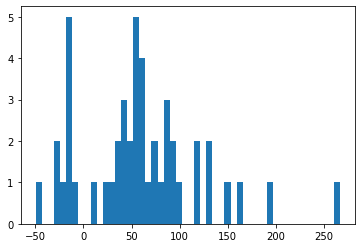

In [21]:
plt.hist(avgProfitState['profit'], bins=50)
plt.show()

Here limits are arbitrarily chosen

In [22]:
avgProfitStateDict = avgProfitState['profit'].to_dict()
for i in avgProfitStateDict:
  if(avgProfitStateDict[i]<0):
    avgProfitStateDict[i] = -1
  elif(avgProfitStateDict[i]>100):
    avgProfitStateDict[i] = 1
  else:
    avgProfitStateDict[i] = 0

In [23]:
train['stateIndex'] = train['departure state'].map(avgProfitStateDict)

In [24]:
test['stateIndex'] = test['departure state'].map(avgProfitStateDict)

In [25]:
train = train.drop('departure state', axis=1)
test = test.drop('departure state', axis=1)

**Checking for NULL**

Test might have some NULL

In [26]:
train.isnull().sum(), train.notnull().sum(), test.isnull().sum(), test.notnull().sum()

(id            0
 discount      0
 price         0
 location      0
 class         0
 sub-class     0
 profit        0
 coeff         0
 stateIndex    0
 dtype: int64, id            6700
 discount      6700
 price         6700
 location      6700
 class         6700
 sub-class     6700
 profit        6700
 coeff         6700
 stateIndex    6700
 dtype: int64, id             0
 discount       0
 price          0
 location       0
 class          0
 sub-class      0
 stateIndex    11
 dtype: int64, id            3294
 discount      3294
 price         3294
 location      3294
 class         3294
 sub-class     3294
 stateIndex    3283
 dtype: int64)

In [27]:
test['stateIndex'] = test['stateIndex'].fillna(0)
test.isnull().sum(), test.notnull().sum()

(id            0
 discount      0
 price         0
 location      0
 class         0
 sub-class     0
 stateIndex    0
 dtype: int64, id            3294
 discount      3294
 price         3294
 location      3294
 class         3294
 sub-class     3294
 stateIndex    3294
 dtype: int64)

**Model**

In [28]:
testIDS = test['id'].to_numpy()
Xtrain = train[['discount', 'price', 'location', 'class', 'sub-class', 'stateIndex']].to_numpy()
ytrain = train['coeff'].to_numpy()
ztrain = train['profit'].to_numpy()
Xtest = test[['discount', 'price', 'location', 'class', 'sub-class', 'stateIndex']].to_numpy()

In [29]:
from sklearn.preprocessing import StandardScaler
scl1 = StandardScaler()
XtrainScaled = scl1.fit_transform(Xtrain)
XtestScaled = scl1.transform(Xtest)

**Dtree**

In [30]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(criterion='friedman_mse', splitter='random' ,max_depth=21, min_samples_leaf=4)

from sklearn.model_selection import cross_validate
cv = cross_validate(dtr, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.96005364, 0.95548479, 0.96010103, 0.96074491]),
 array([0.95207747, 0.95788636, 0.94279165, 0.94693557]))

In [31]:
dtr.fit(XtrainScaled, ytrain)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=21,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='random')

**SVM**

In [32]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf', gamma='auto', C=17)

from sklearn.model_selection import cross_validate
cv = cross_validate(svr, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.9487206 , 0.94724617, 0.95105571, 0.95039121]),
 array([0.94068374, 0.9488145 , 0.93384001, 0.93060665]))

In [33]:
svr.fit(XtrainScaled, ytrain)

SVR(C=17, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

**Voting**

In [34]:
from sklearn.ensemble import VotingRegressor
vr = VotingRegressor(estimators=[('svr', svr), ('dtr', dtr)])

from sklearn.model_selection import cross_validate
cv = cross_validate(vr, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95804219, 0.95616258, 0.95814819, 0.95886985]),
 array([0.95212113, 0.95783191, 0.94193461, 0.94554386]))

In [35]:
vr.fit(XtrainScaled, ytrain)

VotingRegressor(estimators=[('svr',
                             SVR(C=17, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False)),
                            ('dtr',
                             DecisionTreeRegressor(ccp_alpha=0.0,
                                                   criterion='friedman_mse',
                                                   max_depth=21,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=4,
                                                   min_samples_split=2,
        

**KNN**

In [36]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(weights='distance', n_neighbors=15)

from sklearn.model_selection import cross_validate
cv = cross_validate(knn, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.99950149, 0.99936278, 0.99955424, 0.99966891]),
 array([0.94344197, 0.95174617, 0.93949802, 0.93701097]))

In [37]:
knn.fit(XtrainScaled, ytrain)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='distance')

**XGB**

In [38]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

from sklearn.model_selection import cross_validate
cv = cross_validate(xgb, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95683597, 0.95539253, 0.95876112, 0.95761093]),
 array([0.95588987, 0.95802891, 0.94679727, 0.94957332]))

In [39]:
xgb.fit(XtrainScaled, ytrain)

[18:54:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

**NN**

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
polypipe = PolynomialFeatures(degree=2)
nnpipe = MLPRegressor(hidden_layer_sizes=(50,50,50,50,50,50,50))

pipe = [('poly', polypipe),('nn', nnpipe)]
nnPipeline = Pipeline(pipe)

In [41]:
cv = cross_validate(nnPipeline, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.95566095, 0.95228075, 0.95955069, 0.95138576]),
 array([0.94164409, 0.95448488, 0.94497242, 0.93880057]))

In [42]:
nnPipeline.fit(XtrainScaled, ytrain)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('nn',
                 MLPRegressor(activation='relu', alpha=0.0001,
                              batch_size='auto', beta_1=0.9, beta_2=0.999,
                              early_stopping=False, epsilon=1e-08,
                              hidden_layer_sizes=(50, 50, 50, 50, 50, 50, 50),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=200, momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=None, shuffle=True, solver='adam',
                              tol=0.0001, validation_fraction=0.1,
                              verbose=False, warm_start=False))],
         verbose=False)

**Stacking**

In [43]:
from sklearn.ensemble import StackingRegressor
stack = StackingRegressor([('xgb', xgb),('svm', svr),('knn', knn),('vot', vr),('nn', nnPipeline)])

cv = cross_validate(stack, XtrainScaled, ytrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([0.97518339, 0.97355072, 0.97428448, 0.97523823]),
 array([0.9567427 , 0.95952094, 0.948521  , 0.95201762]))

In [44]:
stack.fit(XtrainScaled, ytrain)

[18:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:56:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=None,
                  estimators=[('xgb',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg...
                                                                                 50,
        

In [45]:
ypreds = vr.predict(XtestScaled)

**Stage2**

In [46]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X2train = (ytrain*Xtrain[:,1]).reshape(-1,1)
X2test = (ypreds*Xtest[:,1]).reshape(-1,1)

In [47]:
cv = cross_validate(lr, X2train, ztrain, cv=4, n_jobs=4, return_train_score=True)
cv['train_score'], cv['test_score']

(array([1., 1., 1., 1.]), array([1., 1., 1., 1.]))

In [48]:
lr.fit(X2train, ztrain)
zpreds = lr.predict(X2test)

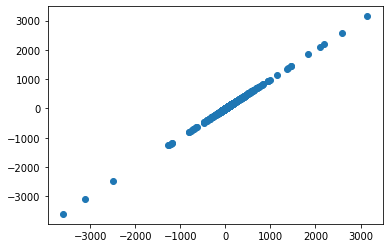

In [49]:
plt.scatter(zpreds,zpreds)

In [50]:
res = pd.DataFrame({'id':testIDS, 'profit':zpreds})
res

,id,profit
0,6701,7.214598
1,6702,32.620177
2,6703,1.101362
3,6704,3.986703
4,6705,37.751847
...,...,...
3289,9990,7.895393
3290,9991,8.667482
3291,9992,43.632766
3292,9993,1.307722


In [51]:
res.to_csv("/content/drive/MyDrive/Competitions/KDAG (1)/FinalResult3.csv", index=False)